In [54]:
from sklearn import tree
from sklearn.datasets import load_files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [55]:
# deterministic, it seems
files = load_files('./avatars', load_content=False)

In [56]:
files.keys()

dict_keys(['filenames', 'target_names', 'target', 'DESCR'])

In [57]:
# labels
files["target"]

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1])

In [58]:
# folder names
files["target_names"]

['custom', 'default']

In [59]:
def file_to_color_histogram(path, bit_depth=8):
    pix = load_pixels(path)
    color_index_array = rgb_to_index(pix, bit_depth=bit_depth)
    
    # count number of occurrences of each value in array of non-negative ints
    color_index_counts = np.bincount(color_index_array, minlength=bit_depth**3)

    # feature vector OMG!
    return color_index_counts

def load_pixels(path):
    # open the file with pillow, resize it, normalize
    image = Image.open(path)
    image = image.resize((16, 16))
    image = image.convert("RGB")

    # use numpy to extra an array of pixel data from the image
    data = image.getdata()
    return np.array(data)

# take an rgb array and run an integer representing the "color index"
def rgb_to_index(pix, bit_depth=8):
    quanitization_factor = 256//bit_depth
    # divide each pixel by 32 and rounds
    pix = pix//quanitization_factor 

    # convert octal numbers to decimal numbers
    # red is multiplied by 64
    # green is multiplied by 8
    # blue is multiplied by 1
    multiplier = np.array([bit_depth**2, bit_depth**1, bit_depth**0])

    return np.sum(pix*multiplier, axis=1)


# take a histogram index and spits out an rgb value
def index_to_rgb(index):
    r = index//64%8
    g = index//8%8
    b = index//1%8
    return np.array([r,g,b])*32

[index_to_rgb(25)]#

[array([ 0, 96, 32])]

In [60]:
# each histogram is an array of 8bits^3 (512 values) corresponding to the 8-bit colors in each image 
# and each element in the array is the count of the number of pixels of that color
histograms = []
for file in files["filenames"]:
    histogram = file_to_color_histogram(file, bit_depth=8)
    histograms.append(histogram)

In [61]:

histograms[0]
len(histograms[0])

512

In [62]:
histograms[0].shape

(512,)

In [63]:
# split our histograms and labels into a "training" set and a "validation" set
# use part of our dataset as a "holdout set" during training to get a sense of how it will work on real images

# (sometimes there's a "test" set that's used when you're developing the model to avoid overoptimizing 
# for the validation set, but we're not using it.)

# we'll use half as training, half as validation

# TODO: considering balancing these sets so they have an equal number of default and custom avatars

training_set = histograms[0:len(histograms)//2]
validation_set = histograms[len(histograms)//2:]

labels = files["target"]
training_labels = labels[0:len(labels)//2]
validation_labels = labels[len(labels)//2:]

[len(training_set), len(validation_set), len(training_labels), len(validation_labels)]


[100, 100, 100, 100]

[Text(133.92000000000002, 190.26, 'X[511] <= 67.5\ngini = 0.48\nsamples = 100\nvalue = [40, 60]'),
 Text(66.96000000000001, 135.9, 'gini = 0.0\nsamples = 33\nvalue = [33, 0]'),
 Text(200.88000000000002, 135.9, 'X[365] <= 0.5\ngini = 0.187\nsamples = 67\nvalue = [7, 60]'),
 Text(133.92000000000002, 81.53999999999999, 'X[511] <= 200.5\ngini = 0.032\nsamples = 61\nvalue = [1, 60]'),
 Text(66.96000000000001, 27.180000000000007, 'gini = 0.0\nsamples = 60\nvalue = [0, 60]'),
 Text(200.88000000000002, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(267.84000000000003, 81.53999999999999, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]')]

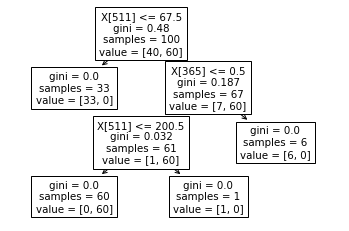

In [64]:
# start with a simple decision tree
# looks at all the data, finds the split that makes one group have most of one label, and another
# group have most of another label

# finds one feature, like the color black. If the number of black pixels is more than 100, that means 80% of 
# the custom images end up in one bucket. 

# (if that is the most discriminating feature that can split that feature into two, it picks that feature))

# find the feature that splits it most coherently into two groups
# then find the second-most splitting feature

# the "feature" in this case will the number of pixels of a specific color
# in this case, likely the gray background of the default avatars

clf = tree.DecisionTreeClassifier()
clf = clf.fit(training_set, training_labels)
tree.plot_tree(clf)

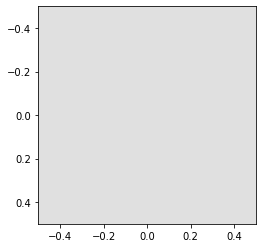

In [65]:
# show color "511"
rgb = index_to_rgb(511)
plt.imshow(rgb.reshape(1,1,3))

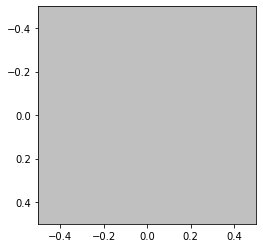

In [66]:
# show color "438"
rgb = index_to_rgb(438)
plt.imshow(rgb.reshape(1,1,3))

In [67]:
# gini coefficient: goodness measure of how coherent the two groups are (zero is perfect, one (or 0.5?) is useless)
# it's what the decision tree uses to determine how to split

# root node: if index 511 fewer or equal to than 67.5 of that color, split into two groups
# group on the left: 33 custom images and no default images
# group on the right: 7 custom, 60 default

# TODO: write a little function that turns an index into a hex color so we can see what it looks like

# throw all of the validation examples through the tree and see which nodes they end up with
prediction = clf.predict(validation_set[:1])[0]
prediction

1

In [68]:
validation_set[0][511], validation_set[0][438], validation_set[0][475]

(138, 0, 0)

In [69]:
predictions = clf.predict(validation_set)
predictions

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1])

In [70]:
# how well did the model do?
np.equal(predictions, validation_labels)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True])

In [71]:
# indices of avatars that are actually defaults but are classified as custom

# single &: elementwise boolean AND of vectors of matrices

# 1: default
# 0: custom

false_customs = np.where((predictions != validation_labels)&(validation_labels == 1))[0]
false_customs

array([], dtype=int64)

In [72]:
# display the false_custom(s)

indices = false_customs + len(histograms)//2
print(indices)

if len(indices) > 0:
    file = files["filenames"][indices[0]]
    Image.open(file)

[]


In [73]:
# indices of avatars that are actually customs but are classified as defaults
# 1: default
# 0: custom

false_defaults = np.where((predictions != validation_labels)&(validation_labels == 0))[0]
false_defaults

array([25, 52, 93])

['./avatars/custom/unwed.png', './avatars/custom/eik.png', './avatars/custom/bason.png']


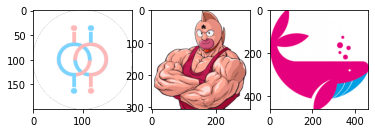

In [74]:
# display the false defaults

false_default_indices = false_defaults + len(histograms)//2

filenames = [files["filenames"][index] for index in false_default_indices]

print(filenames)

images = [np.asarray(Image.open(files["filenames"][index])) for index in false_default_indices]


# show actual images
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])

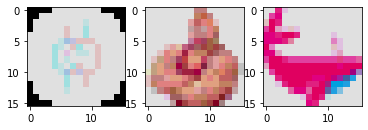

In [75]:
# show quantized images (in which the values have been squished into a smaller range)
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    pix = load_pixels(filenames[i])
    quantized_pix = pix//32 
    quantized_image = quantized_pix*32
    reshaped = quantized_image.reshape([16, 16, 3])
    plt.imshow(reshaped)
    

In [76]:
pix = load_pixels(filenames[0])


# divide each pixel by 32 and round
quantized_pix = pix//32 
# print(quantized_pix)


# convert octal numbers to decimal numbers
# red is multiplied by 64
# green is multiplied by 8
# blue is multiplied by 1
multiplier = np.array([8**2, 8**1, 8**0])

multiplied = quantized_pix*multiplier
print(multiplied)

summed = np.sum(multiplied, axis=1)

# print(summed)

# pix[0],index[0]

[[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [384  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [  0   0   0]
 [  0   0   0]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  48   6]
 [448  56   7]
 [448  56   7]
 [320  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [448  56   7]
 [  0   0   0]
 [448  56   7]
 [448  56   7]
 [448  56 

In [77]:
quantized_pix[0]

array([0, 0, 0])

In [78]:
# print count of pixels with the "511" color
for i in range(len(images)):
    print(histograms[false_default_indices[i]][511])

184
100
132


In [79]:
# what's our accuracy?
np.mean(np.equal(predictions, validation_labels))

0.97

In [80]:
# try it out on a custom avatar
histogram = file_to_color_histogram("smoke-tests/andreasjansson.png")
prediction = clf.predict([histogram])[0]
prediction

0

In [81]:
# try it out on a default avatar
histogram = file_to_color_histogram("smoke-tests/default.png")
prediction = clf.predict([histogram])[0]
prediction

1